[*********************100%***********************]  11 of 11 completed


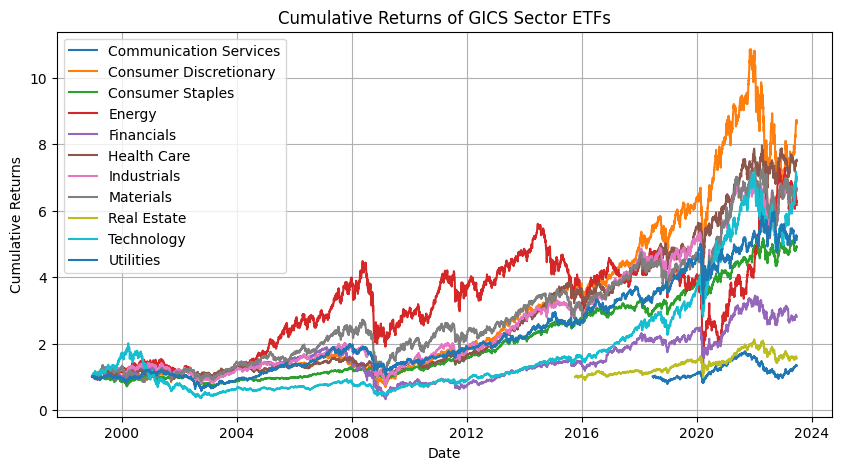

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# List of GICS Sector ETFs
sector_etfs = {
    "XLC": "Communication Services",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLK": "Technology",
    "XLU": "Utilities"
}

data = yf.download(list(sector_etfs.keys()))

# Calculate the cumulative returns
cumulative_returns = (1 + data['Adj Close'].pct_change()).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(10,5))
for etf, sector in sector_etfs.items():
    plt.plot(cumulative_returns.index, cumulative_returns[etf], label=sector)

plt.title("Cumulative Returns of GICS Sector ETFs")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(loc="upper left")
plt.grid()
plt.show()


[*********************100%***********************]  11 of 11 completed


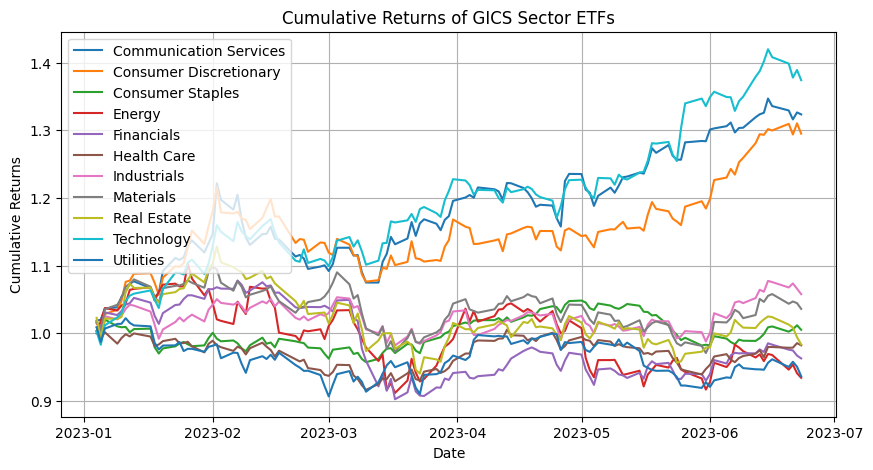

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# List of GICS Sector ETFs
sector_etfs = {
    "XLC": "Communication Services",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLK": "Technology",
    "XLU": "Utilities"
}

data = yf.download(list(sector_etfs.keys()), start="2023-01-01")

# Calculate the cumulative returns
cumulative_returns = (1 + data['Adj Close'].pct_change()).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(10,5))
for etf, sector in sector_etfs.items():
    plt.plot(cumulative_returns.index, cumulative_returns[etf], label=sector)

plt.title("Cumulative Returns of GICS Sector ETFs")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(loc="upper left")
plt.grid()
plt.show()


[*********************100%***********************]  11 of 11 completed
Error: y contains NaN values at index 84


C:\Users\mehdi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


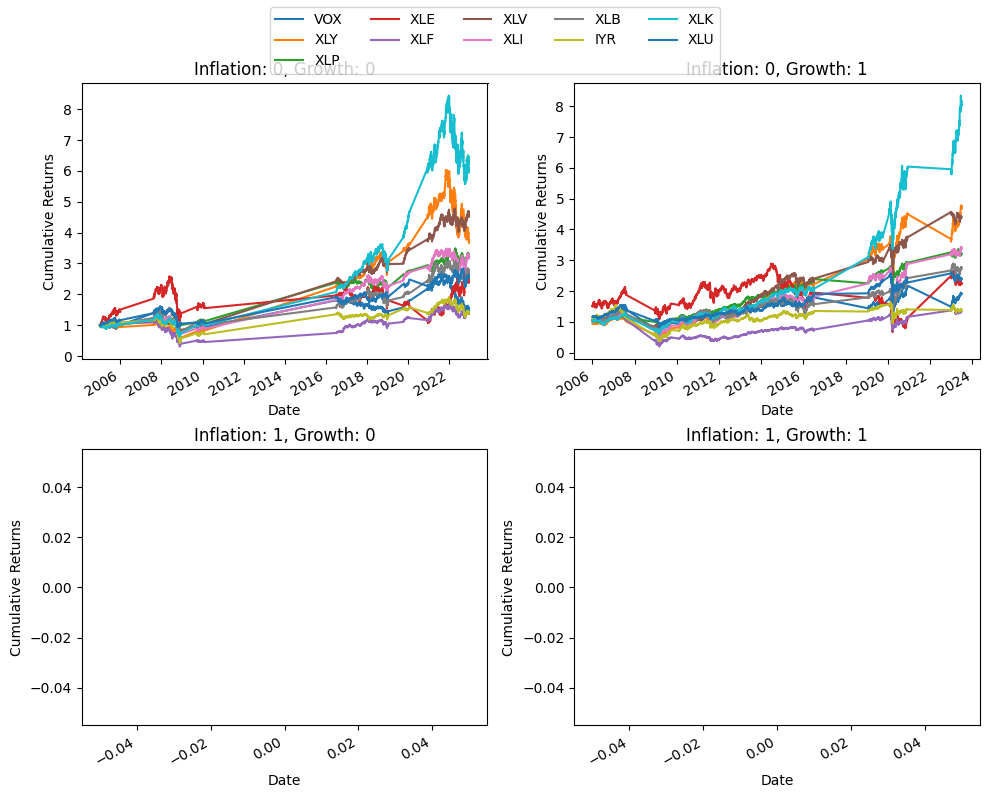

In [13]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression


def convert_date_to_ordinal(date):
    return date.toordinal()


def calculate_slope(X, y):
    """Fit a linear regression model and return the slope"""
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]


# Define sector ETFs
sector_etfs = ["VOX", "XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "IYR", "XLK", "XLU"]

# Fetch ETF data
etfs_data = yf.download(sector_etfs, start='2005-01-01')
etf_close = etfs_data["Close"]

# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')

# Fetch CPI data
cpi_data = fred.get_series('CPIAUCSL')

# Combine the ETF closing prices and the CPI into one DataFrame
combined_df = etf_close.copy()
combined_df['CPI'] = cpi_data


# Calculate the inflation indicator
combined_df['inflation'] = 0
combined_df['CPI'] = combined_df['CPI'].interpolate().fillna(method='ffill')  # Handling NaN values in CPI more effectively

for i in range(12 * 7, len(combined_df)):
    X = combined_df.index[:i].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = np.log(combined_df['CPI'].iloc[:i].values)
    
    # Check if there are any NaN values in y, and print an error message if there are
    if np.isnan(y).any():
        print(f"Error: y contains NaN values at index {i}")
        break
    
    model_1 = LinearRegression()
    model_1.fit(X[-12:], y[-12:].reshape(-1, 1))  # Reshaping y to a 2D array
    
    model_7 = LinearRegression()
    model_7.fit(X[-12*7:], y[-12*7:].reshape(-1, 1))  # Reshaping y to a 2D array
    
    y_pred_1 = model_1.predict(X[-1].reshape(-1, 1))  # Reshaping X to a 2D array
    y_pred_7 = model_7.predict(X[-1].reshape(-1, 1))  # Reshaping X to a 2D array
    
    combined_df.loc[combined_df.index[i], 'inflation'] = 1 if y_pred_7[-1] > y_pred_1[-1] else 0

# Calculate the growth indicator
oil_price = fred.get_series('DCOILWTICO')
etf_log = np.log(etf_close)
oil_log = np.log(oil_price)
etf_oil_log_ratio = (etf_log).div(oil_log, axis=0)

combined_df['growth'] = 0
for date in etf_oil_log_ratio.index:
    one_year_ago = date - DateOffset(years=1)
    last_year_log_ratio = etf_oil_log_ratio[
        (etf_oil_log_ratio.index >= one_year_ago) & (etf_oil_log_ratio.index < date)]
    if not last_year_log_ratio.empty:
        X1 = np.array(last_year_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y1 = last_year_log_ratio.mean(axis=1).values

        valid_indices = ~np.isnan(y1)
        X1 = X1[valid_indices]
        y1 = y1[valid_indices]

        if len(y1) > 0:
            one_year_slope = calculate_slope(X1, y1)

            seven_years_ago = date - DateOffset(years=7)
            last_seven_years_log_ratio = etf_oil_log_ratio[
                (etf_oil_log_ratio.index >= seven_years_ago) & (etf_oil_log_ratio.index < date)]

            if not last_seven_years_log_ratio.empty:
                X7 = np.array(last_seven_years_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
                y7 = last_seven_years_log_ratio.mean(axis=1).values

                valid_indices = ~np.isnan(y7)
                X7 = X7[valid_indices]
                y7 = y7[valid_indices]

                if len(y7) > 0:
                    seven_years_slope = calculate_slope(X7, y7)
                    combined_df.loc[date, 'growth'] = int(one_year_slope > seven_years_slope)

# Calculate cumulative returns
cumulative_returns = (1 + combined_df[sector_etfs].pct_change()).cumprod()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for i, (inflation, growth) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    ax = axes[i]
    mask = (combined_df['inflation'] == inflation) & (combined_df['growth'] == growth)
    data_to_plot = cumulative_returns[mask]
    data_to_plot.plot(ax=ax, legend=False)
    ax.set_title(f'Inflation: {inflation}, Growth: {growth}')
    ax.set_ylabel('Cumulative Returns')
    ax.set_xlabel('Date')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
